# LDA topic analysis of sentences

Note: 

The notebook loads a "f1000_tokenized_LDA_sentence_ITER.pkl".

The notebook saves logs and outputs in the folder "f1000_LDA_Sentence_Run_ITER". 

ITER indicates the iteration of the model (starting from 0).

Adjust load & save settings accordingly.

## Configuration

In [6]:
import csv
import sys
import pathlib
import numpy as np
import pandas as pd
import re
from collections import defaultdict  # For word frequency
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import logging  # Setting up the loggings to monitor gensim
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
    
import pyLDAvis.gensim 

Define ITER.

In [7]:
ITER = '0'

Load and output folder settings. 

In [12]:
path_load_tsv = '../pickles/f1000_tokenized_LDA_sentence_'+ITER+'.tsv'
out_folder = './f1000_LDA_Sentence_Run_'+ITER+'/'
#Create folder if it doesn't exist.
pathlib.Path(out_folder).mkdir(exist_ok=True) 

Define number of topics.

In [13]:
num_topics = '2'

Logger settings.

In [14]:
log_file_name = out_folder + 'gensim_' + num_topics +'.log'

handlers = [logging.FileHandler(log_file_name,mode='w'), logging.StreamHandler()]
logging.basicConfig(handlers = handlers,
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

Load data from tsv.

In [15]:
df = pd.read_csv(path_load_tsv,sep='\t',quoting=csv.QUOTE_NONE)
df.drop(columns=['Unnamed: 0'],inplace=True)
# Split the token column
df['token']=df['token'].str.split(',')

txt_dist = defaultdict(int)
j=0
for sent in df.token:
    for i in sent:
        txt_dist[i] += 1

print('\nNumber of unique words in dataset: ',len(txt_dist))


Number of unique words in dataset:  60445


## Simple Exploration

Convert the word-frequency pairs to a dataframe

In [16]:
txtdist_df = pd.DataFrame({'Word':list(txt_dist.keys()), 'Freq':list(txt_dist.values())}).sort_values(by=['Freq'],axis=0,ascending=False)
txtdist_df.head()

,Word,Freq
60,'author',8652
92,['author',7034
23,'study',6310
112,'datum',5787
418,'provide',4437


Plot the Count VS Word Frequency (counts the number of words that appear X times)

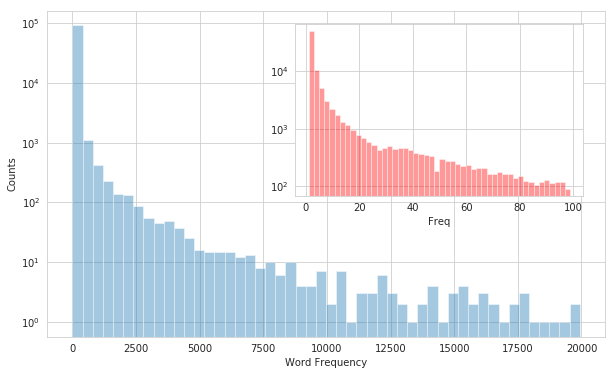

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(txtdist_df.loc[txtdist_df['Freq'] < 20000,'Freq'],kde=False,ax=ax);
ax.set(yscale="log")
ax.set_xlabel('Word Frequency')
ax.set_ylabel('Counts')
left, bottom, width, height = [0.47, 0.45, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
sns.distplot(txtdist_df.loc[txtdist_df['Freq'] < 100,'Freq'],kde=False,ax=ax2,color='r');
ax2.set(yscale="log");

Plot the 20 most common words.

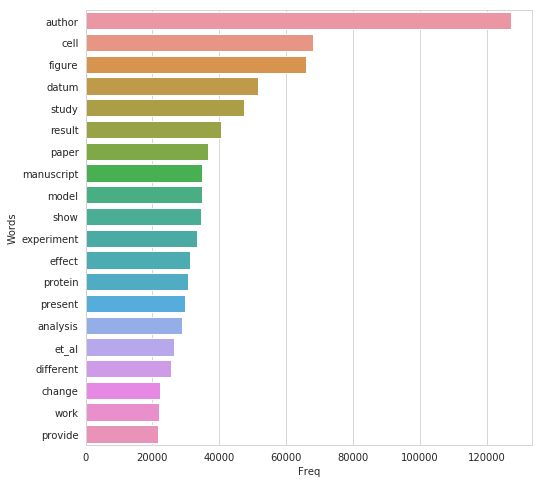

In [9]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=txtdist_df.head(20), y = "Word", x = "Freq")
ax.set(ylabel = 'Words')
plt.show()

## Topic Modeling

Create Dictionary, corpus and Term-Document Frequency matrix.

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(df['token'])
print('\nDict size (no filter): ',len(id2word))
id2word.filter_extremes(no_below=20, no_above=0.75)
print('\nDict size (after filter): ',len(id2word))

# Create Corpus
texts = df['token']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print('\nNumber of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

2019-07-09 18:27:17,941:INFO:adding document #0 to Dictionary(0 unique tokens: [])
2019-07-09 18:27:18,140:INFO:adding document #10000 to Dictionary(10843 unique tokens: ['accomplish', 'aim', 'detail', 'exception', 'fairly']...)
2019-07-09 18:27:18,337:INFO:adding document #20000 to Dictionary(15560 unique tokens: ['accomplish', 'aim', 'detail', 'exception', 'fairly']...)
2019-07-09 18:27:18,538:INFO:adding document #30000 to Dictionary(19000 unique tokens: ['accomplish', 'aim', 'detail', 'exception', 'fairly']...)
2019-07-09 18:27:18,743:INFO:adding document #40000 to Dictionary(22022 unique tokens: ['accomplish', 'aim', 'detail', 'exception', 'fairly']...)
2019-07-09 18:27:18,941:INFO:adding document #50000 to Dictionary(24628 unique tokens: ['accomplish', 'aim', 'detail', 'exception', 'fairly']...)
2019-07-09 18:27:19,140:INFO:adding document #60000 to Dictionary(26760 unique tokens: ['accomplish', 'aim', 'detail', 'exception', 'fairly']...)
2019-07-09 18:27:19,338:INFO:adding docum


Dict size (no filter):  94305

Dict size (after filter):  17611

Number of unique tokens: 17611
Number of documents: 697424


Set training parameters.

In [11]:
passes = 30
iterations = 1000
eval_every = 10  # For monitoring

Run model.

In [12]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=int(num_topics), 
                                           random_state=100,
                                           eval_every = eval_every,
                                           passes=passes,
                                           iterations = iterations,
                                           per_word_topics=True)

2019-07-09 18:27:41,714:INFO:using symmetric alpha at 0.05263157894736842
2019-07-09 18:27:41,715:INFO:using symmetric eta at 0.05263157894736842
2019-07-09 18:27:41,719:INFO:using serial LDA version on this node
2019-07-09 18:27:41,762:INFO:running online LDA training, 19 topics, 30 passes over the supplied corpus of 697424 documents, updating every 30000 documents, evaluating every ~300000 documents, iterating 1000x with a convergence threshold of 0.001000
2019-07-09 18:27:41,763:INFO:training LDA model using 15 processes
2019-07-09 18:27:42,320:INFO:PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/697424, outstanding queue size 1
2019-07-09 18:27:42,374:INFO:PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/697424, outstanding queue size 2
2019-07-09 18:27:42,377:INFO:PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/697424, outstanding queue size 3
2019-07-09 18:27:42,399:INFO:PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/697424,

Save model.

In [13]:
out_file = out_folder + 'Model_' + num_topics
lda_model.save(out_file)
print('\nModel saved at location '+ out_file)

2019-07-09 20:13:31,270:INFO:saving LdaState object under /project/LDA_Sentence_Run_0/Model_19.state, separately None
2019-07-09 20:13:31,376:INFO:saved /project/LDA_Sentence_Run_0/Model_19.state
2019-07-09 20:13:31,448:INFO:saving LdaMulticore object under /project/LDA_Sentence_Run_0/Model_19, separately ['expElogbeta', 'sstats']
2019-07-09 20:13:31,449:INFO:storing np array 'expElogbeta' to /project/LDA_Sentence_Run_0/Model_19.expElogbeta.npy
2019-07-09 20:13:31,526:INFO:not storing attribute id2word
2019-07-09 20:13:31,526:INFO:not storing attribute state
2019-07-09 20:13:31,527:INFO:not storing attribute dispatcher
2019-07-09 20:13:31,581:INFO:saved /project/LDA_Sentence_Run_0/Model_19



Model saved at location /project/LDA_Sentence_Run_0/Model_19


Check model convergence.

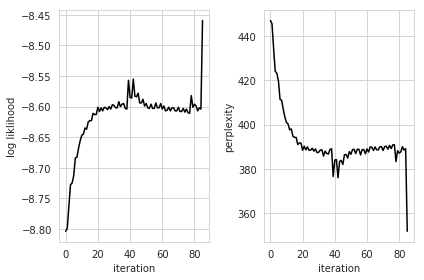

In [18]:
from peertax.LDA_Diagnostic import LDA_Scores, LDA_Conv
iter_no, perplexity, likelihood = LDA_Conv(out_folder,num_topics)
plt.subplot(1,2,1)
plt.plot(iter_no,likelihood,c="black")
plt.ylabel("log liklihood")
plt.xlabel("iteration")

plt.subplot(1,2,2)
plt.plot(iter_no,perplexity,c="black")
plt.ylabel("perplexity")
plt.xlabel("iteration")
plt.tight_layout()

## Post-processing

Compute perplexity score of model (might take long).

In [14]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

2019-07-09 20:17:52,011:INFO:-8.459 per-word bound, 351.9 perplexity estimate based on a held-out corpus of 697424 documents with 6878237 words



Perplexity:  -8.458819685065581


Compute coherence scores (c_v and umass)

In [15]:
cv_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
cv_lda = cv_model_lda.get_coherence()

umass_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence="u_mass")
umass_lda = umass_model_lda.get_coherence()

print('\nCoherence Score (C_V): ', cv_lda)
logging.info('Coherence Score (C_V): %s' % cv_lda) 
print('\nCoherence Score (UMass): ', umass_lda)
logging.info('Coherence Score (UMass): %s' % umass_lda) 
print('\n')

2019-07-09 20:17:52,024:INFO:using ParallelWordOccurrenceAccumulator(processes=15, batch_size=64) to estimate probabilities from sliding windows
2019-07-09 20:18:34,455:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,527:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,529:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,529:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,528:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,530:INFO:accumulator serialized
2019-07-09 20:18:34,533:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,535:INFO:accumulator serialized
2019-07-09 20:18:34,532:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,537:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,538:INFO:serializing accumulator to return to master...
2019-07-09 20:18:34,539:INFO:accumulator serialized
2019-07-09 20:1


Coherence Score (C_V):  0.47251506026870027

Coherence Score (UMass):  -4.125555341878669




Get top topics and average topic coherence.

In [16]:
top_topics = lda_model.top_topics(corpus)

from pprint import pprint
pprint(top_topics)

2019-07-09 20:18:53,389:INFO:CorpusAccumulator accumulated stats from 1000 documents
2019-07-09 20:18:53,397:INFO:CorpusAccumulator accumulated stats from 2000 documents
2019-07-09 20:18:53,404:INFO:CorpusAccumulator accumulated stats from 3000 documents
2019-07-09 20:18:53,413:INFO:CorpusAccumulator accumulated stats from 4000 documents
2019-07-09 20:18:53,421:INFO:CorpusAccumulator accumulated stats from 5000 documents
2019-07-09 20:18:53,428:INFO:CorpusAccumulator accumulated stats from 6000 documents
2019-07-09 20:18:53,435:INFO:CorpusAccumulator accumulated stats from 7000 documents
2019-07-09 20:18:53,442:INFO:CorpusAccumulator accumulated stats from 8000 documents
2019-07-09 20:18:53,449:INFO:CorpusAccumulator accumulated stats from 9000 documents
2019-07-09 20:18:53,456:INFO:CorpusAccumulator accumulated stats from 10000 documents
2019-07-09 20:18:53,463:INFO:CorpusAccumulator accumulated stats from 11000 documents
2019-07-09 20:18:53,470:INFO:CorpusAccumulator accumulated stat

[([(0.049978998, 'model'),
   (0.030367298, 'interesting'),
   (0.030281246, 'study'),
   (0.024115494, 'work'),
   (0.019898383, 'finding'),
   (0.018734237, 'new'),
   (0.018354364, 'datum'),
   (0.018284522, 'provide'),
   (0.016087405, 'paper'),
   (0.01595056, 'important'),
   (0.01569939, 'present'),
   (0.014791354, 'overall'),
   (0.013807896, 'result'),
   (0.012754616, 'manuscript'),
   (0.0117432205, 'novel'),
   (0.010385298, 'field'),
   (0.0086861495, 'mechanism'),
   (0.008433676, 'analysis'),
   (0.007957997, 'system'),
   (0.00613105, 'propose')],
  -3.3473817537400827),
 ([(0.041333895, 'author'),
   (0.028077433, 'manuscript'),
   (0.02276864, 'paper'),
   (0.021409702, 'address'),
   (0.020909121, 'think'),
   (0.020811463, 'point'),
   (0.018026631, 'discussion'),
   (0.014776821, 'result'),
   (0.014695489, 'concern'),
   (0.013608058, 'need'),
   (0.012991285, 'discuss'),
   (0.01270058, 'interpretation'),
   (0.012588797, 'issue'),
   (0.011744268, 'comment'),
 

Save visualization as an html file.

In [17]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
file_vis = out_folder + 'Model_' + num_topics + '.html'
pyLDAvis.save_html(vis, file_vis)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Visualize the topic map.

In [19]:
pyLDAvis.display(vis)